## Basic Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from loss_optimization.accuracy_score import encode_y

import time
seed = 100

In [2]:
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp, PauliList

from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit_algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals



## Data Loading

In [3]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.668720,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.409180,-2.094395,0
2,-0.184800,2.636412,0.154505,-3.141593,-3.141593,-0.959801,-1.547992,-1.989675,1
3,-2.771994,-0.331525,0.257508,-1.681863,-2.443461,-0.510333,-2.902821,-3.141593,0
4,-3.141593,1.184017,-1.081532,-0.920265,-1.893868,0.894254,2.787459,-1.884956,1


In [4]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)





In [5]:
# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [6]:
x_train.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
724,-2.771994,0.363099,1.699550,-3.141593,-3.141593,-0.070229,-2.639904,-0.628319
431,-2.032795,-0.331525,0.669520,-2.126128,-2.510303,-0.294963,-1.872615,-1.361357
561,-3.141593,3.110019,0.257508,-1.110664,-1.106613,0.725703,-2.004073,-2.408554
571,-2.402394,0.963001,1.802553,-3.141593,-3.141593,-1.025348,-2.631855,-3.141593
136,-3.141593,0.015787,0.463514,-1.491463,-2.770246,-0.257508,-1.749204,-3.141593


In [7]:
y_train.head(5)

724    0
431    0
561    1
571    0
136    0
Name: Outcome, dtype: int64

In [8]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]

In [9]:
x_train_A.head(5)


,Pregnancies,Glucose,BloodPressure,SkinThickness
724,-2.771994,0.363099,1.699550,-3.141593
431,-2.032795,-0.331525,0.669520,-2.126128
561,-3.141593,3.110019,0.257508,-1.110664
571,-2.402394,0.963001,1.802553,-3.141593
136,-3.141593,0.015787,0.463514,-1.491463


In [10]:
x_train_B.head(5)

,Insulin,BMI,DiabetesPedigreeFunction,Age
724,-3.141593,-0.070229,-2.639904,-0.628319
431,-2.510303,-0.294963,-1.872615,-1.361357
561,-1.106613,0.725703,-2.004073,-2.408554
571,-3.141593,-1.025348,-2.631855,-3.141593
136,-2.770246,-0.257508,-1.749204,-3.141593


In [11]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [12]:
new_y_train = encode_y(y_train)
new_y_test = encode_y(y_test)

## Data Embedding

In [13]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)                # Create a quantum circuit
    feature_param = ParameterVector("Theta", feature_dims)  # Create a list of parameters
    for qubit in range(feature_dims):                       # Rotate each qubit by the corresponding angle
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [14]:
embedding, feature_params = angle_encoding(4)               # Create an angle encoding circuit for 4 features

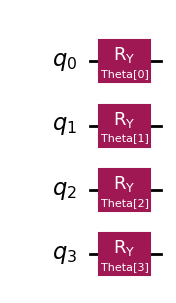

In [15]:
embedding.draw(output='mpl',style='iqx')

In [16]:
print(feature_params)

Theta, ['Theta[0]', 'Theta[1]', 'Theta[2]', 'Theta[3]']


## Tensor Network

In [17]:
from tensor_network.ttn import TTN

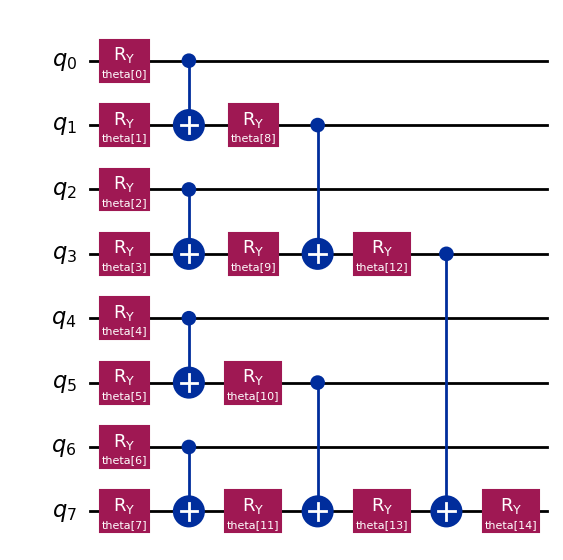

In [18]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

## Circuit Cutting

#### Find the Best Possible Cut

In [19]:
from circuit_knitting.cutting import partition_problem
from circuit_knitting.cutting.cut_finding.cco_utils import qc_to_cco_circuit
circuit_ckt = qc_to_cco_circuit(ttn)

In [20]:
from qiskit.quantum_info import PauliList
import numpy as np
from circuit_knitting.cutting.cut_finding.circuit_interface import SimpleGateList
from circuit_knitting.cutting.cut_finding.lo_cuts_optimizer import LOCutsOptimizer
from circuit_knitting.cutting.cut_finding.optimization_settings import (
    OptimizationSettings,
)
from circuit_knitting.cutting.cut_finding.quantum_device_constraints import (
    DeviceConstraints,
)

In [21]:
settings = OptimizationSettings(seed=12345)

settings.set_engine_selection("CutOptimization", "BestFirst")


qubits_per_qpu = 4


for qubits_per_qpu in range(qubits_per_qpu, 1, -1):
    print(f"\n\n---------- {qubits_per_qpu} Qubits per QPU ----------")

    constraint_obj = DeviceConstraints(qubits_per_qpu=qubits_per_qpu)
    interface = SimpleGateList(circuit_ckt)

    op = LOCutsOptimizer(interface, settings, constraint_obj)

    out = op.optimize()

    print(
        " Gamma =",
        None if (out is None) else out.upper_bound_gamma(),
        ", Min_gamma_reached =",
        op.minimum_reached(),
    )
    if out is not None:
        out.print(simple=True)
    else:
        print(out)

    print(
        "Subcircuits:",
        interface.export_subcircuits_as_string(name_mapping="default"),
        "\n",
    )



---------- 4 Qubits per QPU ----------
 Gamma = 3.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=20, gate_name='cx', qubits=[3, 7]))]
Subcircuits: AAAABBBB 



---------- 3 Qubits per QPU ----------
 Gamma = 27.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=5, gate_name='cx', qubits=[2, 3])), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=8, gate_name='cx', qubits=[4, 5])), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=20, gate_name='cx', qubits=[3, 7]))]
Subcircuits: AABACDDD 



---------- 2 Qubits per QPU ----------
 Gamma = 27.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=14, gate_name='cx', qubits=[1, 3])), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_loc

The first cut has the minimum $\gamma$, so we will go by that partioning 

Found solution using 1 cuts with a sampling overhead of 9.0.
Gate Cut at index 20


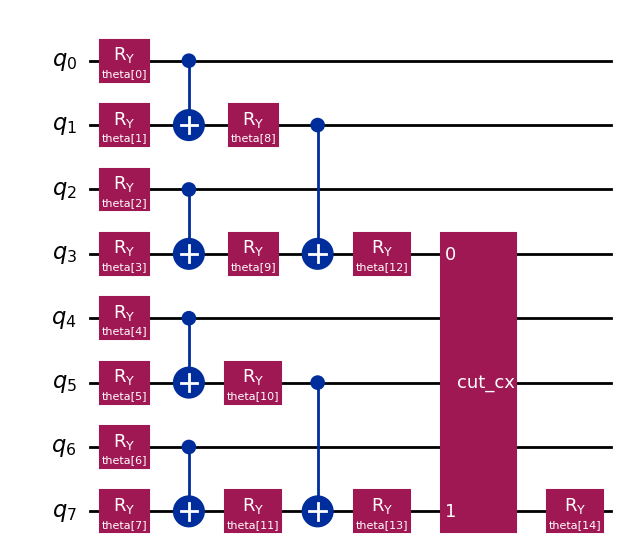

In [22]:
from circuit_knitting.cutting import (
    OptimizationParameters,
    DeviceConstraints,
    find_cuts,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_qpu=6)

cut_circuit, metadata = find_cuts(ttn, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at index {cut[1]}")
cut_circuit.draw("mpl",style='iqp')

In [23]:
observables = PauliList(["ZIIIIIII"])

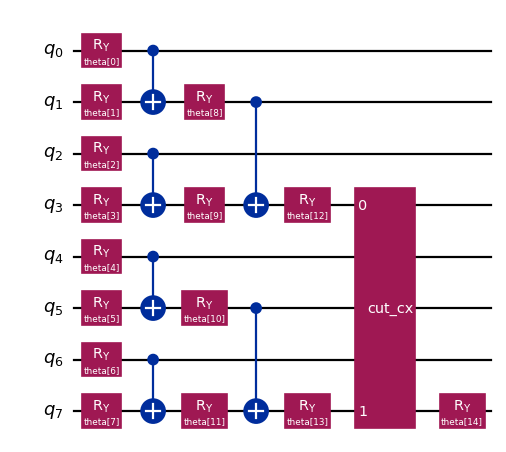

In [27]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observables, ttn, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1,style='iqp')

In [29]:
partitioned_problem = partition_problem(circuit=qc_w_ancilla, partition_labels="AAAABBBB", observables=observables_expanded)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [30]:
sub_observables

{'A': PauliList(['IIII']), 'B': PauliList(['ZIII'])}

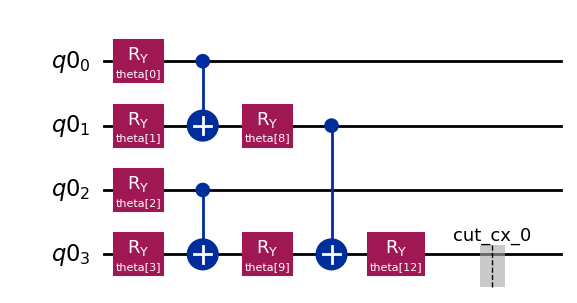

In [31]:
sub_circuits["A"].draw("mpl", style="iqp")

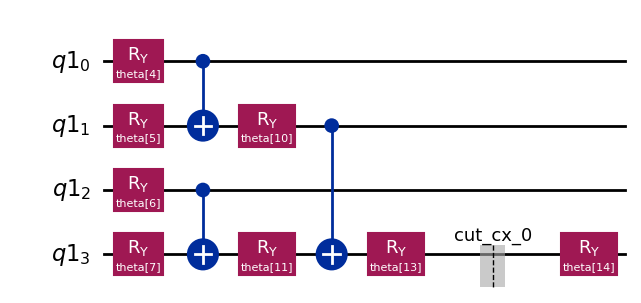

In [32]:
sub_circuits["B"].draw("mpl", style="iqp")

In [33]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 9.0


### Sub Experiments

In [34]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

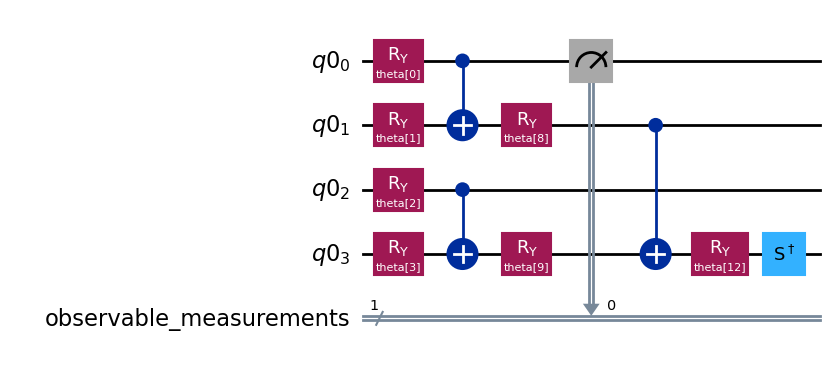

In [36]:
subexperiments["A"][0].draw("mpl", style="iqp")  # measurement on first qubit

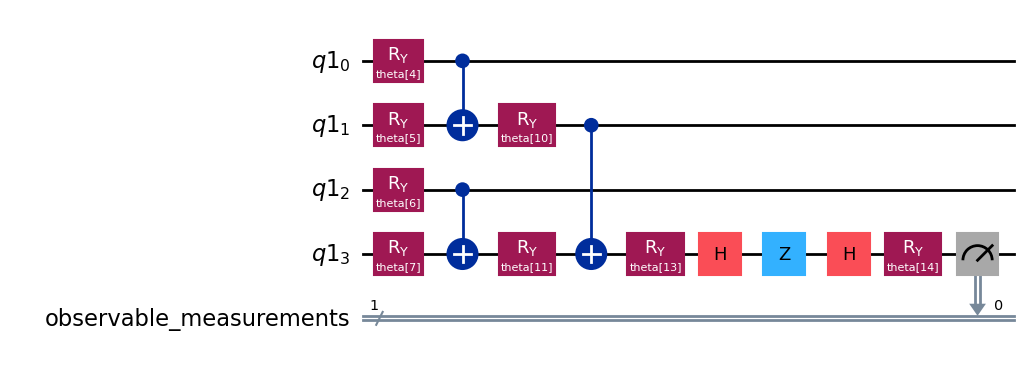

In [37]:
subexperiments["B"][3].draw("mpl", style="iqp")  # measurement on last qubit

## Neural Network Training

In [38]:
from qiskit_machine_learning.neural_networks import SamplerQNN, NeuralNetwork
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from typing import Callable

In [ ]:
# from qiskit_ibm_provider import IBMProvider
# provider = IBMProvider()
# qasm_backend = provider.get_backend("ibmq_qasm_simulator")

In [77]:
sim = AerSimulator(method="automatic")

In [78]:
sampler = Sampler(backend_options={"simulator": sim}, transpile_options={"optimization_level": 3})
#sampler = Sampler(backend_options={"simulator": sim})

### Sampler

In [79]:
from primitives.custom_sampler_qnn import CustomSampler

#### For subexperiments["A"]

In [80]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [81]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
    input_gradients=False,
)

In [82]:
weights_A = algorithm_globals.random.random(7)
forward_output = sampler_qcnn.forward(
    input_data=x_train_A,
    weights=weights_A,
)

Running Time for Forward Pass: %s seconds 3.892058849334717


In [83]:
# forward output is a dictionary of 6 subex_circ items.
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(len(forward_output[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.24707031 0.75292969 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.25390625 0.74609375 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.20214844 0.34082031 0.04980469 0.40722656 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.19238281 0.35839844 0.05957031 0.38964844 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.25390625 0.74609375 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.24023438 0.75976562 0.         0.         0.         0.
  0.         0.

In [84]:
input_grad, weights_grad = sampler_qcnn.backward(
    input_data=x_train_A,
    weights=weights_A
)

Running Time for Backward Pass: %s seconds 90.73806238174438


In [86]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 7)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[ 0.79052734  0.          0.          0.          0.
    0.          0.        ]
  [-0.79052734  0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.      

#### For subexperiments["B"]

In [87]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [88]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits2, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [89]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn2._forward(
    input_data=x_train_B,
    weights=weights_B,
)

Running Time for Forward Pass: %s seconds 6.3342413902282715


In [90]:
print(f"Output shape for {len(x_train_A)} samples: {forward_output2[0].shape}")
print(len(forward_output2[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output2[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.51269531 0.48730469 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.48828125 0.51171875 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.75488281 0.24511719 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.27832031 0.72167969 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.19628906 0.32910156 0.29394531 0.18066406 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.20507812 0.32128906 0.26757812 0.20605469 0.         0.
  0.         0.

In [91]:
input_grad2, weights_grad2 = sampler_qcnn2._backward(
    input_data=x_train_B,
    weights=weights_B
)

In [ ]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad2[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad2[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 8)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[-0.50878906  0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.50878906  0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.     

## Loss and Optimization

In [ ]:
from qiskit_machine_learning.utils.loss_functions import L2Loss
from loss_optimization.custom_cross_entropy_loss import CustomCrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from loss_optimization.objective_func import CustomMultiClassObjectiveFunction
# from loss_optimization.callback import callback
from loss_optimization.optimization import create_objective, minimizer, print_optimizer_results

In [ ]:
def callback_spsa(nfev=None, params=None, fval=None, stepsize=None, accepted=None):
    """
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    # objective_func_vals = loss
    global objective_func_vals

    if (nfev % 3) == 0:
        objective_func_vals.append(fval)
        print(f"SPSA Epoch {len(objective_func_vals)}: {fval:.5f}")

def callback_cobyla(weights, obj_func_eval):
    # clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print(f"COBYLA Epoch {len(objective_func_vals)}: {obj_func_eval:.5f}")

In [ ]:
objective_func_vals = []
# loss = L2Loss()
loss = CustomCrossEntropyLoss()
# optimizer = COBYLA(maxiter=5)
optimizer = SPSA(maxiter=50, callback=callback_spsa)
# optimizer = GradientDescent(maxiter=2) # This doesn't work yet. The gradient shape doesn't match.

#### Optimizer Result for sub-circuits["A"]

In [ ]:
initial_point = np.random.random((7,))
function = CustomMultiClassObjectiveFunction(x_train_A, y_train, sampler_qcnn, loss)

In [ ]:
# Optimizer result for 0th circuit for sub-circuit-A
start_time = time.time()
optimizer_result_A0 = minimizer(function, function.objective0, function.gradient0, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A1: %s seconds", running_time)

start_time = time.time()
optimizer_result_A1 = minimizer(function, function.objective1, function.gradient1, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A2: %s seconds", running_time)

start_time = time.time()
optimizer_result_A2 = minimizer(function, function.objective2, function.gradient2, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A3: %s seconds", running_time)

start_time = time.time()
optimizer_result_A3 = minimizer(function, function.objective3, function.gradient3, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A4: %s seconds", running_time)

start_time = time.time()
optimizer_result_A4 = minimizer(function, function.objective4, function.gradient4, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A5: %s seconds", running_time)

start_time = time.time()
optimizer_result_A5 = minimizer(function, function.objective5, function.gradient5, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A6: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 6.88574481010437
Running Time for Forward Pass: %s seconds 5.705564737319946
Running Time for Forward Pass: %s seconds 5.778653621673584
Running Time for Forward Pass: %s seconds 5.484687805175781
Running Time for Forward Pass: %s seconds 5.672916889190674
Running Time for Forward Pass: %s seconds 5.454464912414551
Running Time for Forward Pass: %s seconds 5.456941604614258
Running Time for Forward Pass: %s seconds 6.287803888320923
Running Time for Forward Pass: %s seconds 5.6996917724609375
Running Time for Forward Pass: %s seconds 5.874071359634399
Running Time for Forward Pass: %s seconds 5.371009826660156
Running Time for Forward Pass: %s seconds 5.7070372104644775
Running Time for Forward Pass: %s seconds 5.804652452468872
Running Time for Forward Pass: %s seconds 5.571355104446411
Running Time for Forward Pass: %s seconds 5.4692604541778564
Running Time for Forward Pass: %s seconds 5.536808729171753
Running Time for Forward Pass: %s seco

In [ ]:
optimizer_results_A = [optimizer_result_A0, optimizer_result_A1, optimizer_result_A2, optimizer_result_A3, optimizer_result_A4, optimizer_result_A5]

In [ ]:
# Print results from 6 sub-experiments of sub-circuit-A
for opt_result in optimizer_results_A:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [-1.07932844  0.88816889 -0.6663622   0.97401284  0.48966871  1.82286874
  0.12849388]
The final value of the minimization: 2.975364101540058
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-1.0785208  -0.51412857 -0.37247252  0.49020378  1.19197915  0.04519932
  0.62225766]
The final value of the minimization: 2.9661652057839194
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-1.22070015  0.66287406 -0.25943525 -1.10643305 -0.83027612  0.89907652
 -1.0927342 ]
The final value of the minimization: 0.6345437389724942
The final gradient of the minimization: None
The total number of function ev

Text(0.5, 1.0, 'Training loss')

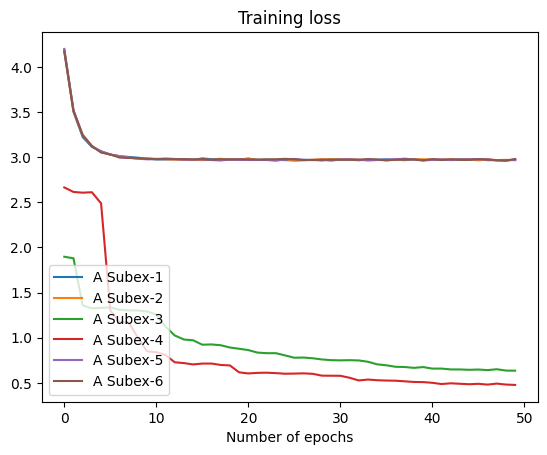

In [ ]:
plt.plot(objective_func_vals[:50], label="A Subex-1")
plt.plot(objective_func_vals[50:100], label="A Subex-2")
plt.plot(objective_func_vals[100:150], label="A Subex-3")
plt.plot(objective_func_vals[150:200], label="A Subex-4")
plt.plot(objective_func_vals[200:250], label="A Subex-5")
plt.plot(objective_func_vals[250:300], label="A Subex-6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
objective_func_vals.clear()
objective_func_vals

[]

#### Optimizer Result for sub-circuits["B"]

In [ ]:
initial_point2 = np.random.random((8,))
function2 = CustomMultiClassObjectiveFunction(x_train_B, y_train, sampler_qcnn2, loss)

In [ ]:
# Optimizer result for 0th circuit for sub-circuit-B
start_time = time.time()
optimizer_result_B0 = minimizer(function2, function2.objective0, function2.gradient0, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B1 = minimizer(function2, function2.objective1, function2.gradient1, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B2: %s seconds", running_time)

start_time = time.time()
optimizer_result_B2 = minimizer(function2, function2.objective2, function2.gradient2, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B3: %s seconds", running_time)

start_time = time.time()
optimizer_result_B3 = minimizer(function2, function2.objective3, function2.gradient3, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B4: %s seconds", running_time)

start_time = time.time()
optimizer_result_B4 = minimizer(function2, function2.objective4, function2.gradient4, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B5: %s seconds", running_time)

start_time = time.time()
optimizer_result_B5 = minimizer(function2, function2.objective5, function2.gradient5, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B6: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 6.286863565444946
Running Time for Forward Pass: %s seconds 6.087194442749023
Running Time for Forward Pass: %s seconds 6.1717634201049805
Running Time for Forward Pass: %s seconds 6.359912157058716
Running Time for Forward Pass: %s seconds 6.199450969696045
Running Time for Forward Pass: %s seconds 6.340600967407227
Running Time for Forward Pass: %s seconds 6.044464588165283
Running Time for Forward Pass: %s seconds 6.300871133804321
Running Time for Forward Pass: %s seconds 6.17350697517395
Running Time for Forward Pass: %s seconds 6.220984697341919
Running Time for Forward Pass: %s seconds 6.18820333480835
Running Time for Forward Pass: %s seconds 6.2221434116363525
Running Time for Forward Pass: %s seconds 6.238685607910156
Running Time for Forward Pass: %s seconds 6.201963186264038
Running Time for Forward Pass: %s seconds 6.254490613937378
Running Time for Forward Pass: %s seconds 6.311119079589844
Running Time for Forward Pass: %s second

In [ ]:
optimizer_results_B = [optimizer_result_B0, optimizer_result_B1, optimizer_result_B2, optimizer_result_B3, optimizer_result_B4, optimizer_result_B5]

In [ ]:
# Print results from 6 sub-experiments of sub-circuit-B
for opt_result in optimizer_results_B:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [ 0.44057534  2.1864663   0.13490433  0.66936653  1.05735287 -0.00577478
  0.0597358  -1.57760916]
The final value of the minimization: 2.7096159116981053
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [ 0.0961531  -0.48461471  2.20156633 -1.60830679 -1.05528121  2.24920187
 -0.07709883 -1.5685588 ]
The final value of the minimization: 3.151745643470558
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-0.22782625 -1.73310398 -0.87471697  3.28565418  2.39058287  2.53673695
 -0.59257812 -0.83773985]
The final value of the minimization: 2.831137070793349
The final gradient of the minimization: N

Text(0.5, 1.0, 'Training loss')

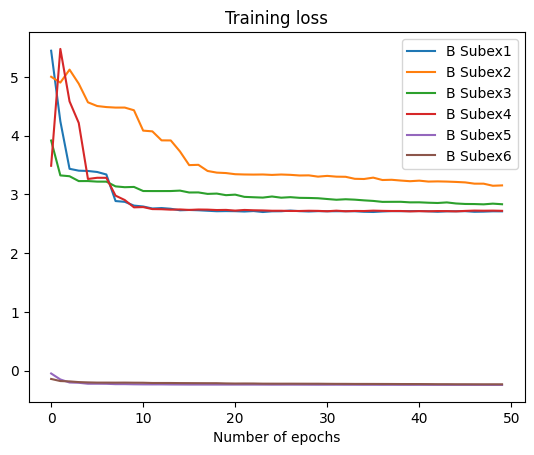

In [ ]:
plt.plot(objective_func_vals[:50], label="B Subex1")
plt.plot(objective_func_vals[50:100], label="B Subex2")
plt.plot(objective_func_vals[100:150], label="B Subex3")
plt.plot(objective_func_vals[150:200], label="B Subex4")
plt.plot(objective_func_vals[200:250], label="B Subex5")
plt.plot(objective_func_vals[250:300], label="B Subex6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
objective_func_vals.clear()
objective_func_vals

[]

### At this point, the training is complete. 
We have 12 lists of 7 or 8 parameter values that will now be used to make predictions on the test cases. 
New subcircuits will be built using these parameter values and then their results will be used to reconstruct expectation values. This process will occur for all the inputs in the test set.


Let us think of the training process as a box that we can tune/edit while training on the train set. However, once the training process is complete, the box is locked and provided to the user. The user can now send test data to the box and get its desired output.

However, in the case of circuit cutting, instead of having one box, we have multiple boxes. In our case, we have a total of 12 boxes (6 boxes per cut). These 12 boxes are trained independently of each other and locked after the training process is complete. The user, now, instead of sending the test data to one box, splits it into 2 parts that are sent to these 12 boxes. The 12 boxes produce quasi-probability distributions respective to the circuits they implement which are then reconstructed to produce the expectation value according to the test input. This process is repeated for every data point in the test dataset.

## Reconstruct Expectation Values and Testing

In [ ]:
from circuit_knitting.cutting import reconstruct_expectation_values
from qiskit_aer.primitives import Sampler
from qiskit.primitives import SamplerResult
from loss_optimization.accuracy_score import get_accuracy_score, predict
from circuit_cut.reconstruct_exp_val import get_subcircuit_results, get_dict_sampler_results, get_reconstructed_expvals

### Reconstructing for train accuracy

In [ ]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [ ]:
train_results_A = get_subcircuit_results(x_train_A, final_circuits, optimizer_results_A, sampler)
train_results_B = get_subcircuit_results(x_train_B, final_circuits2, optimizer_results_B, sampler)

In [ ]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 537 train data inputs
A_dict = get_dict_sampler_results(x_train_A, subexperiments["A"], train_results_A)
B_dict = get_dict_sampler_results(x_train_B, subexperiments["B"], train_results_B)

In [ ]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [ ]:
y_predicted = predict(reconstructed_expvals)

In [ ]:
# accuracy_score function encodes y_train inside the function. Therefore, pass original y_train here.
train_score1 = get_accuracy_score(new_y_train, y_predicted)
train_score2 = get_accuracy_score(y_train, y_predicted)
print(f"The Train Accuracy of the model is: {train_score1, train_score2}")

The Train Accuracy of the model is: (0.633147113594041, 0.633147113594041)


### Reconstructing for test accuracy

In [ ]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [ ]:
test_results_A = get_subcircuit_results(x_test_A, final_circuits, optimizer_results_A, sampler)
test_results_B = get_subcircuit_results(x_test_B, final_circuits2, optimizer_results_B, sampler)

In [ ]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 231 test data inputs
A_dict = get_dict_sampler_results(x_test_A, subexperiments["A"], test_results_A)
B_dict = get_dict_sampler_results(x_test_B, subexperiments["B"], test_results_B)

In [ ]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [ ]:
y_predicted = predict(reconstructed_expvals)

In [ ]:
# Pass original y_test here.
test_score1 = get_accuracy_score(new_y_test, y_predicted)
test_score2 = get_accuracy_score(y_test, y_predicted)
print(f"The Test Accuracy of the model is: {test_score1, test_score2}")

The Test Accuracy of the model is: (0.6796536796536796, 0.6796536796536796)


In [ ]:
# brand_new_y_train = new_y_train.replace({-1: 1, 1: -1})
# brand_new_y_test = new_y_test.replace({-1: 1, 1: -1})

## Test original circuit for x_test[0]

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendEstimator
from qiskit_aer.primitives import Estimator
from qiskit_aer import AerSimulator
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

In [ ]:
embedding, features = angle_encoding(8)
new_ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
org_circuit = embedding.compose(new_ttn)
# final_circuit.draw()

In [ ]:
# gpu_simulator = AerSimulator(device='GPU')
simulator = AerSimulator()
backend = Estimator(backend_options={"simulator": simulator}, transpile_options={"optimization_level": 3})

In [ ]:
# loss = L2Loss()
loss = CrossEntropyLoss()
# optimizer = COBYLA(maxiter=5)
# optimizer = SPSA(maxiter=5, callback=callback_spsa)

In [ ]:
observable = SparsePauliOp(["ZIIIIIII"])
estimator_qnn = EstimatorQNN(
    estimator=backend,
    circuit=org_circuit,
    observables=observable,
    input_params=features.params,
    weight_params=new_ttn.parameters,
)

In [ ]:
weights = np.random.random(len(new_ttn.parameters))

In [ ]:
# Forward pass
output = estimator_qnn.forward(x_train, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 768 samples: (537, 1)
Output of the forward pass for first sample: [0.06835938]


In [ ]:
# Backward pass
_, weights_grad = estimator_qnn.backward(x_train, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

In [ ]:
initial_point = np.random.random((len(new_ttn.parameters),))

In [ ]:
objective_func_vals = []
classifier = NeuralNetworkClassifier(
    estimator_qnn,
    optimizer=SPSA(maxiter=50, callback=callback_spsa),
    loss=loss,
    # optimizer=COBYLA(maxiter=10),
    initial_point=initial_point,
)

In [ ]:
print(len(x_test.values), len(new_y_test.values))

231 231


In [ ]:
start_time = time.time()
classifier.fit(x_train, new_y_train.values)
end_time = time.time()
running_time = end_time - start_time
print("Running Time%s seconds", running_time)

/Users/saashajoshi/anaconda3/envs/qiskit_x86/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/saashajoshi/anaconda3/envs/qiskit_x86/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


SPSA Epoch 1: -9.00314
SPSA Epoch 2: -9.19728
SPSA Epoch 3: -9.91617
SPSA Epoch 4: -9.73278
SPSA Epoch 5: -9.81750
SPSA Epoch 6: -10.09641
SPSA Epoch 7: -10.09362
SPSA Epoch 8: -10.52323
SPSA Epoch 9: -10.52412
SPSA Epoch 10: -10.42063
SPSA Epoch 11: -10.42690
SPSA Epoch 12: -10.39509
SPSA Epoch 13: -10.54550
SPSA Epoch 14: -10.25579
SPSA Epoch 15: -10.21417
SPSA Epoch 16: -10.02173
SPSA Epoch 17: -10.17903
SPSA Epoch 18: -10.43317
SPSA Epoch 19: -10.02028
SPSA Epoch 20: -10.35346
SPSA Epoch 21: -10.60921
SPSA Epoch 22: -10.43796
SPSA Epoch 23: -10.55991
SPSA Epoch 24: -10.48873
SPSA Epoch 25: -10.55645
SPSA Epoch 26: -10.77438
SPSA Epoch 27: -10.51864
SPSA Epoch 28: -10.42836
SPSA Epoch 29: -10.31098
SPSA Epoch 30: -10.31430
SPSA Epoch 31: -10.48607
SPSA Epoch 32: -10.53681
SPSA Epoch 33: -10.56251
SPSA Epoch 34: -10.46696
SPSA Epoch 35: -10.45181
SPSA Epoch 36: -10.60377
SPSA Epoch 37: -10.49732
SPSA Epoch 38: -10.50980
SPSA Epoch 39: -10.26305
SPSA Epoch 40: -10.46407
SPSA Epoch 41:

Text(0.5, 1.0, 'Training loss')

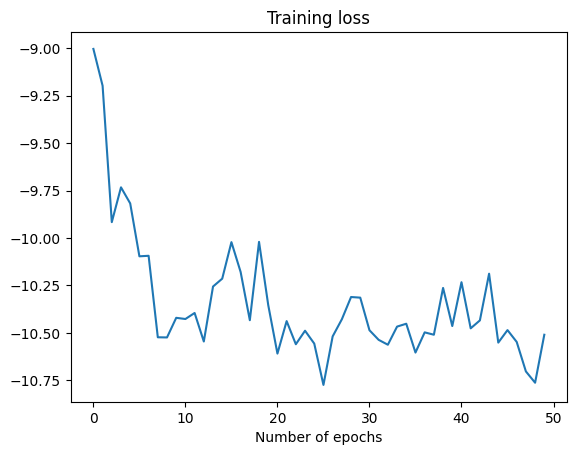

In [ ]:
plt.plot(objective_func_vals)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
y_test_pred = classifier.predict(x_test)
# y_test_pred

In [ ]:
classifier.score(x_train, new_y_train)

0.6871508379888268

In [ ]:
classifier.score(x_test, new_y_test)

0.696969696969697